# 3.1. Data Cleaning (tg.common.ml.dft)

## Overview

The Data Cleaning phase is applicable to the stage when we already have our dataset as a tidy dataframe. This dataframe may not, however, be immediately suitable for machine leaning as it may contain:

* missing continuous values
* non-normalized continuous values
* categorical values in need of transformation

In `sklearn` there are plenty of useful classes to address these problems. The only problem with them is that they do not keep the data in `pd.DataFrame` format, converting them to `numpy` arrays, thus losing the column names and making the debugging much harder.

`tg.common.ml.dft` (we will refer to it as `dft` for shortness) module offers a solution to this problem, wrapping the `sklearn` functionality and ensuring that the column names are preserved. 



## How to do it quickly and painlessly

This demo is mostly describing how `dft` is working and how to customize it. However, in our practice, we have found a perfect setup of data cleaning that we don't really customize, and we believe that this setup may be useful for other projects as well. 

So we will start with this quick solution, and then describe in details how it works. If the customization of data cleaning is not required, you may skip all the following parts of this demo.

In [1]:
import pandas as pd
df = pd.read_csv('titanic.csv')
df = df.set_index('PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
from tg.common.ml import dft

tfac = dft.DataFrameTransformerFactory.default_factory(
    features = ['Pclass', 'Sex', 'Age', 'Cabin','Embarked'],
    max_values_per_category = 5
    )

tfac.fit_transform(df).head()

,Age,Age_missing,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Cabin_C23 C25 C27,Cabin_G6,Cabin_B96 B98,Cabin_OTHER,Cabin_NULL,Embarked_S,Embarked_C,Embarked_Q,Embarked_NULL
PassengerId,,,,,,,,,,,,,,,,
1,-0.530377,False,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.571831,False,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,-0.254825,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.365167,False,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5,0.365167,False,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


`tfac` is a data transformer in the sense of `sklearn`, it has the `fit`, `transform` and `fit_transform` methods.

The default solution:
  * automatically determines if the feature is continuous or categorical
  * performs normalisation and imputation to continous variables, as well as adds the missing indicator
  * for categorical variables:
    * applies one-hot encoding
    * Converts None variable to a string NONE
    * limits the amount of values per feature, placing least-popular values in `OTHER` column (this is crucial, e.g., for decision trees)


## Class structure

With `dft`, you define a single transformer, which is a normal `sklearn` transformer with `fit`, `fit_transform` and `transform` methods. This is a composite transformer that has the following structure:

```
DataFrameTransformer
  ↳ (has) List[DataFrameColumnsTransformer]
               ↳ (is) ContinousTransformer
                      ↳ (has) scaler
                              ↳ (is) sklearn.preprocessing.StandardScaler, etc
                      ↳ (has) 
                              ↳ (is) sklearn.preprocessing.SimpleImputer, etc
                      ↳ (has) missing_indicator
                              ↳ (is) sklearn.impute.MissingIndicator
                              ↳ (is) dft.MissingIndicatorWithReporting
               ↳ (is) CategoricalTransformer2
               ↳ (is) CategoricalTransformer (obsolete version)
                      ↳ (has) replacement_strategy
                              ↳ (is) MostPopularStrategy
                              ↳ (is) TopKPopularStrategy
                      ↳ (has) postprocessor
                              ↳ (is) OneHotEncoderForDataFrame
```

Since such data structures are quite cumbersome to write and read, `dft` also contains a `DataFrameTransformerFactory` class which can be used in the most widespread scenarios to specify `DataFrameTransformer` quickly. 

**Note**: Regarding categorical features, two versions are available, `CategoricalTransformer` and `CategoricalTransformer2`. The latter is recommended: while `CategoricalTransformer` is much more flexible, this flexibility is almost never used in practice, and `CategoricalTransformer2` is significantly faster and memory-efficient.


We will now demonstrate all these classes in details. First, let's take a look at our dataset again:

In [3]:
import pandas as pd
df = pd.read_csv('titanic.csv')
df = df.set_index('PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


`Survived` is a label and should not go through the cleaning. 

`Pclass`, `SibSp`, `Parch` are integers, but in fact they are continous variables and we will convert them to the appropriate type.

In [4]:
for c in ['Pclass','SibSp','Parch']:
    df[c] = df[c].astype(float)

## Continuous transformation

The dataset contains the following continuous columns:

In [5]:
continuous_features = list(df.dtypes.loc[df.dtypes=='float64'].index)
continuous_features

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [6]:
df[continuous_features].describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


All features require normalization, and `Age` requires imputation. Since this is a quite standard case, the default instance of `ContinousTransformer` will do:

In [7]:
tr = dft.DataFrameTransformer([
    dft.ContinousTransformer(
        columns=continuous_features
    )
])
tdf = tr.fit_transform(df)
tdf.head()

,Pclass,Age,SibSp,Parch,Fare,Age_missing
PassengerId,,,,,,
1,0.827377,-0.530377,0.432793,-0.473674,-0.502445,False
2,-1.566107,0.571831,0.432793,-0.473674,0.786845,False
3,0.827377,-0.254825,-0.474545,-0.473674,-0.488854,False
4,-1.566107,0.365167,0.432793,-0.473674,0.420730,False
5,0.827377,0.365167,-0.474545,-0.473674,-0.486337,False


We see new column, `Age_missing`, which is `True` is the `Age` value was missing for this row. For other columns, we don't see this, this is the default behaviour of the `MissingIndicator`

Let's check the distribution of `Age`:

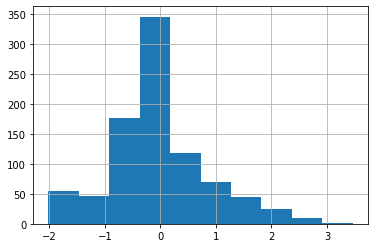

In [8]:
tdf.Age.hist()
pass

By the range of values it's easy to see that the `StandardScaler` was used. We can of course replace the scaler, as well as other components of the transformer

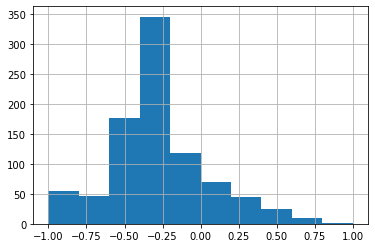

In [9]:
from sklearn.preprocessing import MinMaxScaler

tr = dft.DataFrameTransformer([
    dft.ContinousTransformer(
        columns=continuous_features,
        scaler = MinMaxScaler(feature_range=(-1,1))
    )
])
tr.fit_transform(df).Age.hist()
pass

Some notes on missing indicator. When the sklearn Missing indicator is used, the error is thrown when the column that did not happen to be None in training, does so in test:

In [10]:
import traceback

test_df = pd.DataFrame([dict(Survived=0, Age=30, SibSp=0, Fare=None, Parch=0, PClass=0)]).astype(float)
from sklearn.impute import MissingIndicator

tr = dft.DataFrameTransformer([
    dft.ContinousTransformer(
        columns=continuous_features,
        missing_indicator = MissingIndicator()
    )
])
tr.fit(df)
try:
    tr.transform(test_df)
except ValueError as exp:
    traceback.print_exc() #We catch the exception so the Notebook could proceed uninterrupted

2022-12-28 14:20:25.225323 WARNING: Missing column in ContinuousTransformer


Traceback (most recent call last):
  File "/tmp/ipykernel_16374/777428497.py", line 14, in <module>
    tr.transform(test_df)
  File "/home/yura/Desktop/repos/appalack-ml/tg/common/ml/dft/architecture.py", line 48, in transform
    for res in transformer.transform(df):
  File "/home/yura/Desktop/repos/appalack-ml/tg/common/ml/dft/column_transformers.py", line 90, in transform
    missing = self.missing_indicator.transform(subdf)
  File "/home/yura/anaconda3/envs/ap/lib/python3.8/site-packages/sklearn/impute/_base.py", line 885, in transform
    raise ValueError(
ValueError: The features [4] have missing values in transform but have no missing values in fit.


This effect can be quite annoying if the column has `None` value in exceptionally low amount of fringe cases, so when doing random train/test split this value may become absent. To avoid that, `dft` improves the `sklearn` class:

In [11]:
tr = dft.DataFrameTransformer([
    dft.ContinousTransformer(
        columns=continuous_features,
        missing_indicator = dft.MissingIndicatorWithReporting() # This class is used by default
    )
])
tr.fit(df)
tr.transform(test_df)

2022-12-28 14:20:25.256829 WARNING: Missing column in ContinuousTransformer


2022-12-28 14:20:25.265063 WARNING: Unexpected None in MissingIndicatorWithReporting


2022-12-28 14:20:25.265807 WARNING: Unexpected None in MissingIndicatorWithReporting


,Pclass,Age,SibSp,Parch,Fare,Age_missing
0,0.0,0.020727,-0.474545,-0.473674,0.0,False


As you can see, the exception is replaced with a warning in the `Logger` instead. They keys to the message carry the information about the affected entities:

In [12]:
from tg.common import Logger

Logger.initialize_kibana()

tr.transform(test_df)

{"@timestamp": "2022-12-28T13:20:25.278713+00:00", "message": "Missing column in ContinuousTransformer", "levelname": "WARNING", "logger": "tg", "path": "/home/yura/Desktop/repos/appalack-ml/tg/common/ml/dft/column_transformers.py", "path_line": 75, "column": "Pclass"}


{"@timestamp": "2022-12-28T13:20:25.290459+00:00", "message": "Unexpected None in MissingIndicatorWithReporting", "levelname": "WARNING", "logger": "tg", "path": "/home/yura/Desktop/repos/appalack-ml/tg/common/ml/dft/miscellaneous.py", "path_line": 36, "column": "Pclass"}


{"@timestamp": "2022-12-28T13:20:25.292595+00:00", "message": "Unexpected None in MissingIndicatorWithReporting", "levelname": "WARNING", "logger": "tg", "path": "/home/yura/Desktop/repos/appalack-ml/tg/common/ml/dft/miscellaneous.py", "path_line": 36, "column": "Fare"}


,Pclass,Age,SibSp,Parch,Fare,Age_missing
0,0.0,0.020727,-0.474545,-0.473674,0.0,False


The recommendation is:

* If these None values are potentially critical for the model correctness, specify  `sklearn.impute.MissingIndicator`
* If they aren't, don't specify, so the default `dft.MissingIndicatorWithReporting` will be used. Check output warnings to monitor the issue.

## Categorical values

Categorical variables are processed by `CategoricalTransformer` with the following routine:

* Replace all the values with their string representation (for the sake of type consistancy)
* Also replace None with a provided string constant, `'NONE'` by default. After that, None is treated like normal value of categorical variable
* Apply replacement strategy: e.g. only keep N most popular values and ignore all else.
* Apply post-processing, e.g. One-Hot encoding

These are categorical variables of out dataset:

In [13]:
categorical_variables = list(df.dtypes.loc[df.dtypes!='float64'].index)
categorical_variables

['Survived', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [14]:
df[categorical_variables].head()

,Survived,Name,Sex,Ticket,Cabin,Embarked
PassengerId,,,,,,
1,0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
3,1,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
5,0,"Allen, Mr. William Henry",male,373450,NaN,S


In [15]:
pd.Series({c: len(df[c].unique()) for c in categorical_variables}).sort_values()

Survived      2
Sex           2
Embarked      4
Cabin       148
Ticket      681
Name        891
dtype: int64

I will exclude Ticket and Name from features, because they are near to unique for each row so it does not make sense to include them. I will also exclude `Survived` because it is a label.

In [16]:
for c in ['Ticket','Name','Survived']:
    categorical_variables.remove(c)

In [17]:
df[categorical_variables].isnull().sum(axis=0)

Sex           0
Cabin       687
Embarked      2
dtype: int64

Categorical column transformer essentially does the following:

1. Converts all the values to string format. None/NaN is converted to a `NONE` string (parametrized in constructor)
2. Somehow deals with values: removes excessive values or values unseen during the training by replacing it with something.
3. Postprocesses the result with e.g. one-hot encoding or converting to indices if required by the model.

In [18]:
tr = dft.DataFrameTransformer([
    dft.CategoricalTransformer(
        columns=categorical_variables
    )
])
tdf = tr.fit_transform(df)
tdf.head()

,Sex,Cabin,Embarked
PassengerId,,,
1,male,NONE,S
2,female,C85,C
3,female,NONE,S
4,female,C123,S
5,male,NONE,S


Imagine we performed a train/test split so that `Embarked` was always not null in the training set.

In [19]:
tr = dft.DataFrameTransformer([
    dft.CategoricalTransformer(
        columns=['Embarked']
    )
])
tr.fit(df.loc[~df.Embarked.isnull()])
tr.transform(df.loc[df.Embarked.isnull()])

{"@timestamp": "2022-12-28T13:20:25.390231+00:00", "message": "Unexpected value in MostPopularStrategy", "levelname": "WARNING", "logger": "tg", "path": "/home/yura/Desktop/repos/appalack-ml/tg/common/ml/dft/column_transformers.py", "path_line": 122, "column": "Embarked", "value": "NONE"}


,Embarked
PassengerId,
62,S
830,S


We see it was converted to `S`. This is because by default, `MostPopular` strategy is used, and this strategy replaces the unseen values with the most popular ones. `S` is way more popular than others.

In [20]:
df.groupby(df.Embarked).size()

Embarked
C    168
Q     77
S    644
dtype: int64

For `Cabin` field, however, this strategy doesn't make much sense, because the number of different categories is too high. In one-hot encoding case, the number of columns will be enormous. So we can use `TopKPopularStrategy` in this case

In [21]:
tr = dft.DataFrameTransformer([
    dft.CategoricalTransformer(
        columns=['Cabin'],
        replacement_strategy= dft.TopKPopularStrategy(10,'OTHER')
    )
])
tdf = tr.fit_transform(df)
tdf.groupby('Cabin').size().sort_values(ascending=False)

Cabin
NONE           687
OTHER          175
B96 B98          4
C23 C25 C27      4
G6               4
C22 C26          3
D                3
E101             3
F2               3
F33              3
C65              2
dtype: int64

So we have 11 values, which is a constructor parameter 10 + 1 value for `'OTHER'` (you may replace `'OTHER'` with an arbitrary string constant in constructor). The top-popular category is `'None'`. Still, there are some cabins shared across several passenger, and that might allow us to predict the fate of other passengers in this cabings correctly - but still keeping this in control by limiting the amount of cabins.

After applying replacement strategy, we will _never_ have the values that we didn't have in a training set. This is crucial for sucessful run of the machine learning algorithm that are located down the stream.

All the messages about unexpected values are stored in `TgWarningStorage`

Finally, we can implement one-hot encoding, or other postprocessing, required for many models.

In [22]:
from sklearn.preprocessing import OneHotEncoder

tr = dft.DataFrameTransformer([
    dft.CategoricalTransformer(
        columns=['Embarked','Cabin'],
        postprocessor=dft.OneHotEncoderForDataframe()
    )
])
tr.fit_transform(df).head()

,Embarked_C,Embarked_NONE,Embarked_Q,Embarked_S,Cabin_A10,Cabin_A14,Cabin_A16,Cabin_A19,Cabin_A20,Cabin_A23,...,Cabin_F E69,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_NONE,Cabin_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## `CategoricalTransformer2`

In our practice, we always used `CategoricalTransformer` with `TopKPopularStrategy` and `OneHotEncoderForDataframe`, so we didn't really make any use of the class's flexibility. However, this flexibility adds overheads, and significantly reduces the performance of the class. To address this issue, we developed `CategoricalTransformer2`, which does the very same transformation as `CategoricalTransformer` with `TopKPopularStrategy` and `OneHotEncoderForDataframe`, but in a very efficient way.

In [23]:
tr = dft.DataFrameTransformer([
    dft.CategoricalTransformer2(
        columns=['Embarked','Cabin'],
        max_values=4
    )
])
tr.fit_transform(df).head()

,Embarked_S,Embarked_C,Embarked_Q,Embarked_NULL,Cabin_C23 C25 C27,Cabin_G6,Cabin_OTHER,Cabin_NULL
PassengerId,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Combining transformers

You can combine different transformers for different columns.

The code below basically creates the transformer to feed Titanic Dataset into Logistic Regression

In [24]:
tr = dft.DataFrameTransformer([
    dft.ContinousTransformer(
        columns=continuous_features
    ),
    dft.CategoricalTransformer(
        columns= ['Sex','Embarked'],
        postprocessor=dft.OneHotEncoderForDataframe()
    ),
    dft.CategoricalTransformer2(
        columns=['Cabin'],
        max_values=5
    )
])
tr.fit_transform(df).head()

,Pclass,Age,SibSp,Parch,Fare,Age_missing,Sex_female,Sex_male,Embarked_C,Embarked_NONE,Embarked_Q,Embarked_S,Cabin_C23 C25 C27,Cabin_G6,Cabin_B96 B98,Cabin_OTHER,Cabin_NULL
PassengerId,,,,,,,,,,,,,,,,,
1,0.827377,-0.530377,0.432793,-0.473674,-0.502445,False,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-1.566107,0.571831,0.432793,-0.473674,0.786845,False,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.827377,-0.254825,-0.474545,-0.473674,-0.488854,False,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-1.566107,0.365167,0.432793,-0.473674,0.420730,False,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,0.827377,0.365167,-0.474545,-0.473674,-0.486337,False,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Transformer factories

There are two problems with the transformers. The first is subjective: the initialization code for a large transformer sets is ugly. The second is more problematic: in order to build the transformers, you usually need to see the data first: for instance, to decide, which categorical columns should be processed with default replacement strategy, and which should be processed with `TopKReplacementStrategy`.

Both of these problems are solved by DataFrameTransformerFactory. This is the class is an `sklearn` transformer. When `fit` is called, it creates the DataFrameTransformer according to its setting, and fits this transformer. When transforming, it just passes the data to the transformer that should be created ealier.

The following code is creating the factory for the Titanic dataset:


In [25]:
from functools import partial

tfac = (dft.DataFrameTransformerFactory()
 .with_feature_block_list(['Survived','Name','Ticket'])
 .on_continuous(dft.ContinousTransformer)
 .on_categorical_2()
 .on_rich_category(10, partial(
     dft.CategoricalTransformer, 
     postprocessor=dft.OneHotEncoderForDataframe(), 
     replacement_strategy = dft.TopKPopularStrategy(10,'OTHER')
)))

tfac.fit_transform(df).head()

,Pclass,Age,SibSp,Parch,Fare,Age_missing,Sex_male,Sex_female,Cabin_C23 C25 C27,Cabin_G6,...,Cabin_C22 C26,Cabin_E101,Cabin_F33,Cabin_D,Cabin_OTHER,Cabin_NULL,Embarked_S,Embarked_C,Embarked_Q,Embarked_NULL
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.827377,-0.530377,0.432793,-0.473674,-0.502445,False,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,-1.566107,0.571831,0.432793,-0.473674,0.786845,False,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.827377,-0.254825,-0.474545,-0.473674,-0.488854,False,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-1.566107,0.365167,0.432793,-0.473674,0.420730,False,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5,0.827377,0.365167,-0.474545,-0.473674,-0.486337,False,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


`on_categorical_2` and `on_categorical` are different in the same way as `CategoricalTransformer2` and `CategoricalTransformer`. So, using `on_categorical_2` is advised.

`partial` is used here for the following reason. `on_continuous`, `on_categorical` etc methods receive the function, that accepts the list of column names and creates a `DataFrameColumnTransformer` for them. Normally, we would write something like:

```
on_categorical(
    lambda features: dft.CategoricalTransformer(features, postprocessor=dft.OneHotEncoderForDataframe())
```

But the `DataFrameTransformerFactory` object is typically to be delivered to the remote server, and for this it has to be serializable. Unfortunately, lambdas is Python are not serializable. Therefore, we need to replace them, and `partial` is a good tool.

`dft.DataFrameTransformerFactory` also has methods `default_factory` that essentially return the code block above. Note that we don't have `default_factory_2` method, as there is only one "default" solution, and it works with `CategoricalTransformer2`.